In [3]:
# All Imports
import numpy as np
import pandas as pd

In [ ]:
# SciPy / sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score, precision_score

In [ ]:
###Install spark on google colab
!sudo apt update

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

!tar xf spark-3.2.1-bin-hadoop3.2.tgz

!pip install -q findspark

!pip install pyspark

!pip install py4j



import os

import sys

# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"



import findspark

findspark.init()

findspark.find()



import pyspark



from pyspark.sql import DataFrame, SparkSession

from typing import List

import pyspark.sql.types as T

import pyspark.sql.functions as F

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [4]:
# Spark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkStandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

In [5]:
# EDA

In [8]:
spark = SparkSession.builder.appName("ProsperLinearSVM").getOrCreate()

data = spark.read.csv("Prosper data set.csv", header=True, inferSchema=True)

# Drop missing rows
data = data.dropna(subset=["BorrowerRate"])
data = data.withColumn("BorrowerRateBinary", when(col("BorrowerRate") > 0.222, 1).otherwise(0))

# select min feature
features = ["BorrowerMaximumRate", "ProsperScore", "CreditScoreRangeLower", "CreditScoreRangeUpper"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
scaler = SparkStandardScaler(inputCol="features", outputCol="scaledFeatures")

In [9]:
eda_cols = ["BorrowerMaximumRate", "ProsperScore", "CreditScoreRangeLower", "CreditScoreRangeUpper", "BorrowerRate"]
df_eda = data.select(eda_cols).dropna()

from pyspark.sql.functions import when

median_rate = df_eda.approxQuantile("BorrowerRate", [0.5], 0.001)[0]
df_eda = df_eda.withColumn("BorrowerRateBinary", when(col("BorrowerRate") > median_rate, 1).otherwise(0))

#correlation matrix
correlations = {}
for col1 in eda_cols[:-1] + ["BorrowerRateBinary"]:
    for col2 in eda_cols[:-1] + ["BorrowerRateBinary"]:
        correlations[(col1, col2)] = df_eda.stat.corr(col1, col2)

#convert to Pandas for heatmap
import pandas as pd

cols = eda_cols[:-1] + ["BorrowerRateBinary"]
corr_matrix = pd.DataFrame(index=cols, columns=cols)

for (c1, c2), val in correlations.items():
    corr_matrix.loc[c1, c2] = val

corr_matrix = corr_matrix.astype(float)

In [12]:
df_eda.dtypes

[('BorrowerMaximumRate', 'double'),
 ('ProsperScore', 'int'),
 ('CreditScoreRangeLower', 'int'),
 ('CreditScoreRangeUpper', 'int'),
 ('BorrowerRate', 'double'),
 ('BorrowerRateBinary', 'int')]

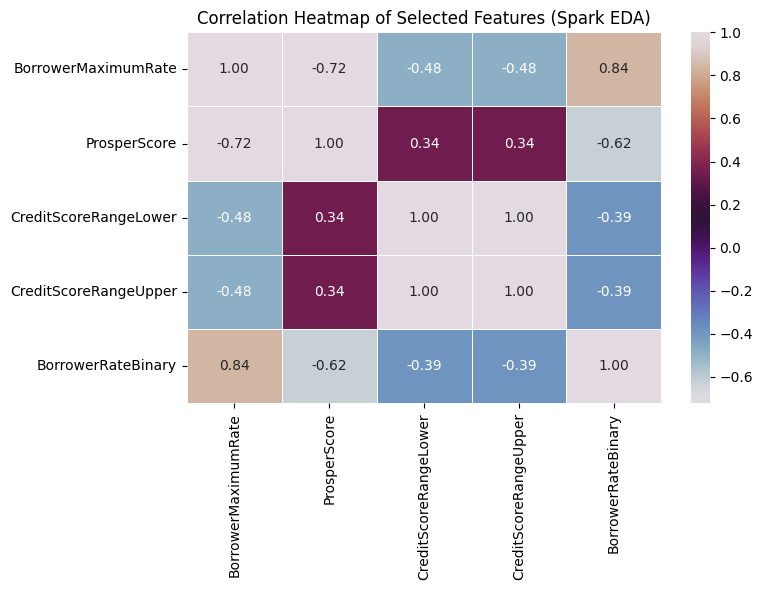

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="twilight", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features (Spark EDA)")
plt.tight_layout()
plt.show()

In [ ]:
# Linear vs. Non-Linear SVM: Spark vs. SciPy

In [ ]:
# Spark: Linear SVM

In [ ]:
pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(data)
processed_data = pipeline_model.transform(data).select("scaledFeatures", "BorrowerRateBinary")
processed_data = processed_data.withColumnRenamed("BorrowerRateBinary", "label")

#split
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

#train SVM
lsvc = LinearSVC(featuresCol="scaledFeatures", labelCol="label")
model = lsvc.fit(train_data)

In [ ]:
# Evaluate

In [ ]:
def evaluate(predictions, label_col="label"):
    tp = predictions.filter((col("prediction") == 1) & (col(label_col) == 1)).count()
    tn = predictions.filter((col("prediction") == 0) & (col(label_col) == 0)).count()
    fp = predictions.filter((col("prediction") == 1) & (col(label_col) == 0)).count()
    fn = predictions.filter((col("prediction") == 0) & (col(label_col) == 1)).count()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    bal_acc = (sens + spec) / 2
    return acc, sens, spec, bal_acc

#predictions
train_pred = model.transform(train_data)
test_pred = model.transform(test_data)

print("Spark - Training Metrics:")
print(evaluate(train_pred))
print("Spark - Testing Metrics:")
print(evaluate(test_pred))

spark.stop()

Spark - Training Metrics:
(0.9989937468554589, 0.997958886135005, 1.0, 0.9989794430675025)
Spark - Testing Metrics:
(0.9994168246100015, 0.998844598497978, 1.0, 0.999422299248989)


In [ ]:
# SciPy: Non-linear SVM

In [ ]:
df = pd.read_csv("Prosper data set.csv")
df = df.dropna(subset=["BorrowerRate"])
df["BorrowerRateBinary"] = (df["BorrowerRate"] > 0.222).astype(int)

#select features
X = df[["BorrowerMaximumRate", "ProsperScore", "CreditScoreRangeLower", "CreditScoreRangeUpper"]]
y = df["BorrowerRateBinary"]

In [ ]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train
model = svm.SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [ ]:
# Evaliate

In [ ]:
def evaluate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred)
    spec = tn / (tn + fp)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    return acc, sens, spec, bal_acc, cm

print("SciPy - Training Metrics:")
print(evaluate_metrics(y_train, y_train_pred))
print("SciPy - Testing Metrics:")
print(evaluate_metrics(y_test, y_test_pred))

SciPy - Training Metrics:
(0.9979818365287588, 0.9962960273077203, np.float64(0.9996423206237929), np.float64(0.9979691739657566), array([[13974,     5],
       [   51, 13718]]))
SciPy - Testing Metrics:
(0.9979818365287588, 0.9967751392553503, np.float64(0.999149177538287), np.float64(0.9979621583968187), array([[3523,    3],
       [  11, 3400]]))


In [ ]:
###END###